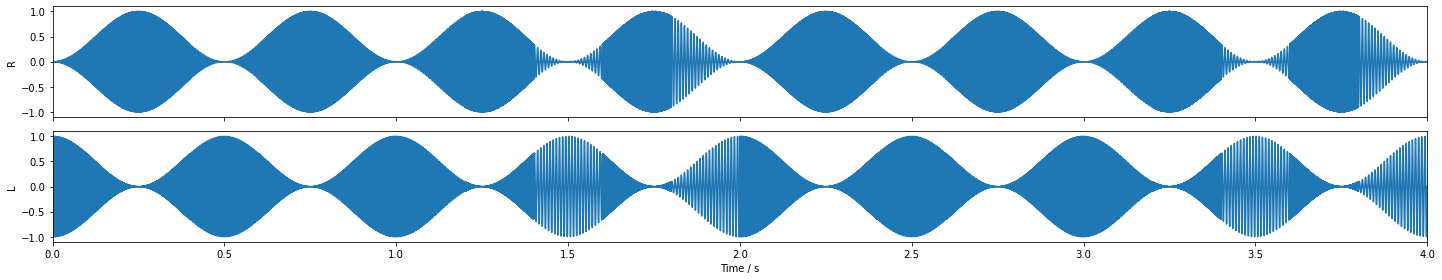

In [26]:
import wavestacker as buffer
import importlib; importlib.reload(buffer)
import numpy as np

def generate_sine_wave(frequency, duration, sample_rate):
    time_array = np.linspace(0, duration, int(sample_rate * duration))
    sine_wave = np.sin(2 * np.pi * frequency * time_array)
    return sine_wave

sample_rate = 44100  # Sample rate in Hz
bf = buffer.StereoAudioBuffer()

# Generate large arrays of sine waves with different frequencies
frequencies = [440, 880, 220, 880, 440, 220, 1760, 110, 1760, 110]
frequencies += frequencies # repeat melody
duration = 0.2  # seconds
time_array = np.linspace(0, duration*len(frequencies), int(sample_rate * duration * len(frequencies)))
large_arrays = [generate_sine_wave(freq, duration, sample_rate) for freq in frequencies]
joined_array = np.concatenate(large_arrays)

# Apply modulation 
channel0 = joined_array * (( np.cos(2 * np.pi * 2 * time_array) / 2) + .5)
channel1 = joined_array * ((-np.cos(2 * np.pi * 2 * time_array) / 2) + .5)

bf.add_audio_data(channel0, channel1)
# audio_buffer.write_to_wav('05.wav')
fig, axs = bf.plot()
# for ax in axs: ax.set_xlim(0,.5)
bf.play()


In [ ]:
stop()

TODO:
- bundle wave generators into class (`synth`?)
- a mixer (class) that manages length, have a track `{data, amplitude, position}`, mixer takes care of max length. atm length has to be given to every function

To make the `MonoAudioBuffer` class agnostic of the specific encoder implementations, you can utilize polymorphism and ensure that all encoders adhere to a common interface or contract. This means each encoder should implement the same set of methods with the same signatures. This way, `MonoAudioBuffer` can interact with any encoder without needing to know the specifics of how the encoder works.

Here's how you can achieve this:

### 1. Define a Common Interface for Encoders

Ensure that all encoders have the same set of methods that `MonoAudioBuffer` expects to call. For example, all encoders should implement `encode`, `plot`, and any other methods that `MonoAudioBuffer` relies on. You've already done this with `encode` and `plot`, which is great.

### 2. Use Encapsulation for Encoder-Specific Logic

Any logic specific to a particular encoding format (e.g., handling of 8-bit vs. 16-bit data) should be encapsulated within the encoder itself. `MonoAudioBuffer` should only call the methods defined in the common interface and should not have to perform any encoder-specific checks or operations.

### 3. Implement a Factory or Dependency Injection

If `MonoAudioBuffer` needs to instantiate encoders itself, consider using a factory pattern that can create encoder instances based on some input parameters or configuration. Alternatively, you can use dependency injection, where the encoder is passed into `MonoAudioBuffer` at instantiation, which you're already doing. This approach allows you to keep `MonoAudioBuffer` decoupled from the encoder implementations.

### Example Adjustments

You're already passing the encoder to `MonoAudioBuffer` upon instantiation, which is a form of dependency injection. To ensure `MonoAudioBuffer` remains agnostic of the encoder details, you might adjust the `write_to_wav` method in `MonoAudioBuffer` to delegate more responsibility to the encoder. For example:

```python
class MonoAudioBuffer:
    # Existing implementation...

    def write_to_wav(self, filename):
        # Prepare common WAV header information...
        with open(filename, 'wb+') as file:
            # Write common WAV header...

            # Delegate writing of audio data to the encoder
            self.encoder.write_audio_data(file, self.data)
```

Then, in each encoder class, implement `write_audio_data` to handle the specifics:

```python
class AmplitudeBinaryEncoder:
    # Existing implementation...

    def write_audio_data(self, file, data):
        # Specific logic for writing 8-bit data...
        pass

class hAmplitudeBinaryEncoder(AmplitudeBinaryEncoder):
    # Existing implementation...

    def write_audio_data(self, file, data):
        # Specific logic for writing 16-bit data...
        pass
```

This way, `MonoAudioBuffer` doesn't need to know how the audio data is written; it just calls `write_audio_data` on whatever encoder it was given. Each encoder takes care of the specifics, ensuring that `MonoAudioBuffer` can work with any encoder that adheres to the expected interface.



In [ ]:

# import player
# import waves

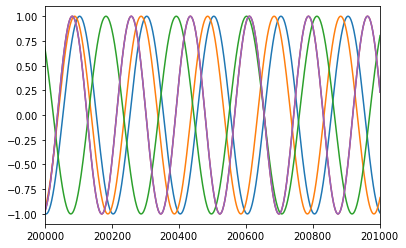

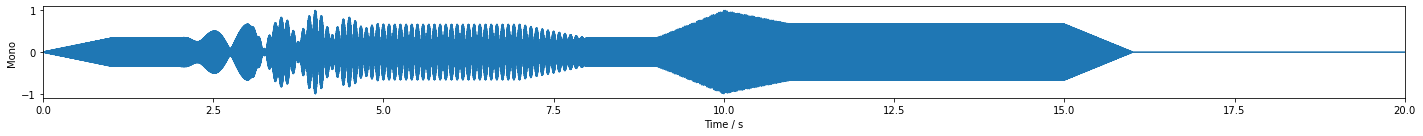

In [28]:
# import buffer
import wavestacker
import importlib; importlib.reload(wavestacker)
import numpy as np
import matplotlib.pyplot as plt

def mix_tracks(tracks): 
    y = np.zeros(tracks[0]['y'].shape)
    for track in tracks:
        y += track['amp'] * track['y']
    y = y / len(tracks)
    return y

def normalize_signal(y):
    max_val = np.max(np.abs(y))
    if max_val == 0: return y  # avoids division by zero
    return y / max_val

def fade_in(t_0, dt, t_max, sample_rate=44100):
    low  = np.zeros(int(t_0 * sample_rate))
    fade = np.linspace(0,1, int(dt * sample_rate))
    high = np.ones(int((t_max-t_0-dt) * sample_rate))
    joined = np.concatenate((low, fade, high))
    fill = np.zeros(t_max*sample_rate - len(joined))
    return np.concatenate((joined, fill))

def fade_out(t_0, dt, t_max, sample_rate=44100):
    high = np.ones(int(t_0 * sample_rate))
    fade = np.linspace(1,0, int(dt * sample_rate))
    low  = np.zeros(int((t_max-t_0-dt) * sample_rate))
    joined = np.concatenate((high, fade, low))
    fill = np.zeros(t_max*sample_rate - len(joined))
    return np.concatenate((joined, fill))

length = 20
t = np.linspace(0, length, length*44100)
tracks = list()

freq = 220
set_in = 0
duration = 4
y  = np.sin(t * freq * (np.pi * 2))
amp = fade_in(set_in,1,length) * fade_out(set_in+duration,1,length) 
tracks.append({'amp':amp, 'y':y})

freq = 222
y  = np.sin(t * freq * (np.pi * 2))
amp = fade_in(2,1,length) * fade_out(7,1,length)
tracks.append({'amp':amp, 'y':y})

freq = 210
y  = np.sin(t * freq * (np.pi * 2))
amp = fade_in(3,1,length) * fade_out(10,1,length)
tracks.append({'amp':amp, 'y':y})

freq = 250
y  = np.sin(t * freq * (np.pi * 2))
amp = fade_in(9,1,length) * fade_out(15,1,length)
tracks.append({'amp':amp, 'y':y})

freq = 250
y  = np.sin(t * freq * (np.pi * 2))
amp = fade_in(9,1,length) * fade_out(15,1,length)
tracks.append({'amp':amp, 'y':y})

y = normalize_signal(mix_tracks(tracks))
bf = buffer.MonoAudioBuffer(encoder=buffer.AmplitudeEncoder_unsignedchar())

fig, ax = plt.subplots()
for tr in tracks:
    ax.plot(tr['y'])
ax.set_xlim(2e5, 2e5+1000)

bf.add_audio_data(y)
bf.plot()
bf.play()

In [3]:
length = 30
t = np.linspace(0, length, length*44100)
tracks = list()

for i in range(length * 1):
    freq = 200 + np.random.randint(80)
    set_in = np.random.randint(length-5)
    duration = 2 + np.random.randint(4)
    y  = np.sin(t * freq * (np.pi * 2))
    amp = fade_in(set_in,1,length) * fade_out(set_in+duration,1,length) 
    tracks.append({'amp':amp, 'y':y})

y = waves.normalize_signal(waves.mix_tracks(tracks))

bf = buffer.MonoAudioBuffer(encoder=buffer.AmplitudeBinaryEncoder_unsignedchar())
bf.add_audio_data(t,y)
bf.plot()
bf.play()

NameError: name 'fade_in' is not defined

In [ ]:
length = 20
t = np.linspace(0, length, length*44100)
tracks = list()

division = 6

for k in range(2):
    frequency = np.random.randint(1000) + 100
    decay = (2 + np.random.randint(10)) * 0.01
    beats = [np.random.randint(2) for i in range(np.random.randint(8)+2)]
    print(beats, frequency, decay)
    
    beats = (beats * division * length)[0:length*division]
    for i, e in enumerate(beats):
        y  = np.sin(t * frequency * (np.pi * 2))
        y  = np.random.rand(len(t)) * 2 - 1
        set_in = (i/division) + 0.0
        amp = fade_in(set_in,.01,length) * fade_out(set_in,decay,length)  / 2 
        amp = amp * e
        tracks.append({'amp':amp, 'y':y})

y = waves.normalize_signal(waves.mix_tracks(tracks))

bf = buffer.MonoAudioBuffer(encoder=buffer.AmplitudeBinaryEncoder_unsignedchar())
bf.add_audio_data(t,y)
bf.plot()
bf.play()

In [ ]:
def fft_filter(data, cutoff_frequency, sampling_rate=44100):
    fft_data = np.fft.fft(data)
    frequencies = np.fft.fftfreq(len(data), d=1/sampling_rate)
    # Create a rectangular window (filter) in the frequency domain
    filter_mask = np.abs(frequencies) < cutoff_frequency
    filtered_fft_data = fft_data * filter_mask
    filtered_data = np.fft.ifft(filtered_fft_data)
    return filtered_data.real

length = 20
t = np.linspace(0, length, length*44100)
tracks = list()

division = 6

for k in range(2):
    frequency = np.random.randint(1000) + 400
    decay = (2 + np.random.randint(10)) * 0.02
    beats = [np.random.randint(2) for i in range(np.random.randint(8)+2)]
    print(beats, frequency, decay)
    
    beats = (beats * division * length)[0:length*division]
    for i, e in enumerate(beats):
        y  = np.random.rand(len(t)) * 2 - 1
        y = fft_filter(y, frequency)
        set_in = (i/division) + 0.0
        amp = fade_in(set_in,.01,length) * fade_out(set_in,decay,length)  / 2 
        amp = amp * e
        tracks.append({'amp':amp, 'y':y})

y = waves.normalize_signal(waves.mix_tracks(tracks))

bf = buffer.MonoAudioBuffer()
bf.add_audio_data(t,y)
bf.plot()
bf.play()

In [ ]:
import numpy as np
import buffer
# import buffer3 as buffer
import importlib; importlib.reload(buffer)

length = 30
mixer = buffer.MonoMixer()

for i in range(int(length * 0.7)):
    freq = 200 + np.random.randint(80)
    set_in = np.random.randint(length)
    duration = np.random.randint(6)
    y  = np.sin(np.linspace(0,3,(duration+2)*44100) * freq * (np.pi * 2))
    amp = np.concatenate(( np.linspace(0,1,44100), np.ones(44100*duration), np.linspace(1,0,44100)))
    mixer.add(y,amp,set_in)

t,y = mixer.get_mix()
print(mixer)

bf = buffer.MonoAudioBuffer()
bf.add_audio_data(y)
bf.plot()
bf.play()

In [ ]:
import numpy as np

def overdrive(x, exponent=3):
    # https://dsp.stackexchange.com/questions/13142/digital-distortion-effect-algorithm
    x = np.where(x == 0, 1e-10, x)  # Avoid division by zero
    result = -np.sign(x) * (1 - np.exp(x**exponent / np.abs(x)))
    result = result / np.max(np.abs(result)) * np.max(np.abs(x)) # normalise
    result -= np.mean(result) # center around zero
    return result

def overdrive2(x):
    x = np.where(x == 0, 1e-10, x)  # Avoid division by zero
    y = x / (1 + np.abs(x))
    return y

length = 30
mixer0 = buffer.MonoMixer()
mixer1 = buffer.MonoMixer()

for i in range(int(length * 0.7)):
    freq = 200 + np.random.randint(80)
    set_in = np.random.randint(length)
    duration = np.random.randint(6)
    y = np.sin(np.linspace(0,3,(duration+2)*44100) * freq * (np.pi * 2))
    amp = np.concatenate(( np.linspace(0,1,44100), np.ones(44100*duration), np.linspace(1,0,44100)))
    mixer0.add(y,amp,set_in)
    y = overdrive2(y)
    mixer1.add(y,amp,set_in)

In [ ]:
t,y = mixer0.get_mix()
bf = buffer.MonoAudioBuffer()
bf.add_audio_data(y)
bf.plot()
bf.play()

In [ ]:
t,y = mixer1.get_mix()
bf = buffer.MonoAudioBuffer()
bf.add_audio_data(y)
bf.plot()
bf.play()

In [ ]:
import importlib; importlib.reload(buffer)
bf = buffer.MonoAudioBuffer(encoder=buffer.AmplitudeBinaryEncoder_unsignedchar())
print(bf.encoder.get_format())
bf.add_audio_data(t,y)

bf.plot()
bf.play()

In [ ]:
import numpy as np

def overdrive(x, exponent=3):
    # https://dsp.stackexchange.com/questions/13142/digital-distortion-effect-algorithm
    x = np.where(x == 0, 1e-10, x)  # Avoid division by zero
    result = -np.sign(x) * (1 - np.exp(x**exponent / np.abs(x)))
    result = result / np.max(np.abs(result)) * np.max(np.abs(x)) # normalise
    result -= np.mean(result) # center around zero
    return result

def overdrive2(x):
    x = np.where(x == 0, 1e-10, x)  # Avoid division by zero
    y = x / (1 + np.abs(x))
    return y

signal = np.linspace(0, 10, 400)  # Example signal

signal = np.sin(signal*np.pi)
plt.plot(signal, label='sine')
plt.plot(overdrive(signal, 6), label='concave overdrive')
plt.plot(overdrive2(signal), label='convex overdrive')

In [ ]:
length = 30
mixer0 = buffer.MonoMixer()
mixer1 = buffer.MonoMixer()
mixer2 = buffer.MonoMixer()

for i in range(int(length * 0.7)):
    freq = 200 + np.random.randint(80)
    set_in = np.random.randint(length)
    duration = np.random.randint(6)
    y  = np.sin(np.linspace(0,3,(duration+2)*44100) * freq * (np.pi * 2))
    amp = np.concatenate(( np.linspace(0,1,44100), np.ones(44100*duration), np.linspace(1,0,44100)))
    mixer0.add(y,amp,set_in)
    mixer1.add(overdrive(y,6),amp,set_in)
    mixer2.add(overdrive2(y),amp,set_in)

t,y = mixer0.get_mix()
print(mixer0)
bf = buffer.MonoAudioBuffer()
bf.add_audio_data(t,y)
bf.plot()
bf.write_to_wav('00_clean.wav')
bf1 = buffer.MonoAudioBuffer()
bf1.add_audio_data(*mixer1.get_mix())
bf1.write_to_wav('00_concave.wav')
bf2 = buffer.MonoAudioBuffer()
bf2.add_audio_data(*mixer2.get_mix())
bf2.write_to_wav('00_convex.wav')
bf.play()

In [ ]:
t,y = mixer1.get_mix()
print(mixer0)
bf = buffer.MonoAudioBuffer()
bf.add_audio_data(t,y)
bf.plot()
# bf.write_to_wav('00_clean.wav')
bf.play()

In [ ]:
import matplotlib.pyplot as plt 


fig, ax = plt.subplots(figsize=(20,2))
ax.axhline(0, lw=0.5, color='black')
ax.plot(t,y)
ax.set_xlim(0, max(t))

In [ ]:
import wave

def validate_wav_header(wav_file_path):
    try:
        with wave.open(wav_file_path, 'rb') as wav_file:
            # Extract parameters
            audio_format = wav_file.getcomptype()
            num_channels = wav_file.getnchannels()
            sample_width = wav_file.getsampwidth()
            frame_rate = wav_file.getframerate()
            num_frames = wav_file.getnframes()

            # Validate
            if audio_format != 'NONE':
                print("This WAV file is compressed; only uncompressed PCM WAV files are supported.")
                return False
            
            print(f"Number of channels: {num_channels}")
            print(f"Sample width (bytes): {sample_width}")
            print(f"Frame rate (samples per second): {frame_rate}")
            print(f"Number of frames: {num_frames}")
            print(f"Total duration (seconds): {num_frames / frame_rate}")

            return True
    except wave.Error as e:
        print(f"Error reading WAV file: {e}")
        return False
    except FileNotFoundError:
        print(f"File not found: {wav_file_path}")
        return False


validate_wav_header('temp_file.wav')

In [ ]:
bf = buffer.MonoAudioBuffer(sample_rate=8000)#encoder=buffer.AmplitudeBinaryEncoder_f())
bf.add_audio_data(t,y)

fig, ax = bf.plot()
# ax.set_xlim(10,10.05)

bf.play()

In [ ]:

validate_wav_header('temp_file.wav')

In [ ]:
bf = buffer.MonoAudioBuffer()#encoder=buffer.AmplitudeBinaryEncoder_f())
bf.add_audio_data(t,y)
bf.plot()
bf.play()

In [ ]:
24696000 / 1543500

In [ ]:
import numpy as np
import buffer


mixer = buffer.MonoMixer()

for i in range(50):
    freq = 190 + np.random.randint(20)
    offset = i*2
    duration = 4
    y  = np.sin(np.linspace(0,3,(duration+2)*44100) * freq * (np.pi * 2))
    amp = np.concatenate(( np.linspace(0,1,44100), np.ones(44100*duration), np.linspace(1,0,44100)))
    mixer.add(y,amp,offset)
    
t,y = mixer.get_mix()
print(mixer)

bf = buffer.MonoAudioBuffer()
bf.add_audio_data(t,y)
bf.plot()
bf.play()

In [ ]:
import numpy as np
import buffer3 as buffer


mixer = buffer.MonoMixer()

for i in range(50):
    freq = 190 + np.random.randint(20)
    offset = i*2
    duration = 4
    y = np.sign(np.sin(np.linspace(0,3,(duration+2)*44100) * freq * (np.pi * 2)))
    amp = np.concatenate(( np.linspace(0,1,44100), np.ones(44100*duration), np.linspace(1,0,44100)))
    mixer.add(y,amp,offset)
    
t,y = mixer.get_mix()
print(mixer)

bf = buffer.MonoAudioBuffer()
bf.add_audio_data(t,y*0.5)
bf.plot()
bf.play()

In [31]:
# np.random.seed(187) 

def bandpass_filter(signal, center_frequency=1000, bandwidth=100, sample_rate=44100):
    """
    Apply a band-pass filter to the input signal.

    Args:
    signal (array_like): The input signal.
    sample_rate (int, optional): The sample rate of the input signal (default: 44100 Hz).
    center_frequency (float, optional): The center frequency of the band-pass filter in Hz (default: 1000 Hz).
    bandwidth (float, optional): The bandwidth of the band-pass filter in Hz (default: 100 Hz).

    Returns:
    array_like: The filtered signal.
    """
    t = np.linspace(0, len(signal) / sample_rate, len(signal), endpoint=False)
    filter_kernel = np.exp(-0.5 * ((2 * np.pi * t * bandwidth) ** 2)) * np.cos(2 * np.pi * t * center_frequency)
    pad_width = len(filter_kernel) // 2
    filtered_signal = np.convolve(np.pad(signal, (pad_width, pad_width), mode='constant'), filter_kernel, mode='same')
    filtered_signal = filtered_signal[:len(signal)]
    return filtered_signal / max(abs(filtered_signal))

import numpy as np

def lowpass_filter(signal, cutoff_frequency=1000, transition_width=100, sample_rate=44100):
    """
    Apply a low-pass filter to the input signal.

    Args:
    signal (array_like): The input signal.
    sample_rate (int, optional): The sample rate of the input signal (default: 44100 Hz).
    cutoff_frequency (float, optional): The cutoff frequency of the low-pass filter in Hz (default: 1000 Hz).
    transition_width (float, optional): The transition width of the filter in Hz (default: 100 Hz).

    Returns:
    array_like: The filtered signal.
    """

    # Generate time array
    duration = len(signal) / sample_rate
    t = np.linspace(0, duration, len(signal), endpoint=False)

    # Generate low-pass filter kernel (Gaussian-shaped)
    lowpass_filter = np.sinc(2 * cutoff_frequency * (t - duration / 2))

    # Apply Hamming window to the filter kernel for smooth transition
    alpha = transition_width / sample_rate
    hamming_window = 0.54 - 0.46 * np.cos(2 * np.pi * t / duration)
    lowpass_filter *= np.where(np.abs(t - duration / 2) <= alpha / 2, hamming_window, 1)

    # Pad the input signal to ensure output length matches input length
    pad_width = len(lowpass_filter) // 2
    signal_padded = np.pad(signal, (pad_width, pad_width), mode='constant')

    # Convolve padded input signal with low-pass filter
    filtered_signal = np.convolve(signal_padded, lowpass_filter, mode='valid')

    return filtered_signal


def drum(frequency, decay):
    'https://www.bluskysoftware.com/audacity/manual/man/risset_drum.html'
    attack  = int(0.02*44100)
    release = int(decay*44100)
    amp = np.concatenate((np.linspace(0,1,attack), np.linspace(1,0,release)**3))
    sine  = np.sin(np.linspace(0, (attack+release)/44100, attack+release ) * frequency * (np.pi * 2))
    enharmonic  = np.sin(np.linspace(0, (attack+release)/44100, attack+release ) * frequency * 2 * (np.pi * 2))
    sub  = np.sin(np.linspace(0, (attack+release)/44100, attack+release ) * frequency / 2 * (np.pi * 2))
    white_noise = np.random.rand(attack+release) * 2 - 1
    noise = bandpass_filter(white_noise, frequency, 100)
    mix = 0.6 * sine + 0.1 * enharmonic + 0.1 * noise  + 0.2 * sub
    return mix , amp


def good_one():
    frequencies = [329, 125]
    patterns = [[0, 1], [1, 1, 1, 1, 0, 1, 0]]
    decays = [0.4, 0.15]
    return zip(patterns, frequencies, decays)

def techno_beat():
    frequencies = [12, 44]
    patterns = [[1, 1, 0, 0, 0], [1, 0, 0, 0, 1]]
    decays = [0.22, 0.22]
    return zip(patterns, frequencies, decays)

def random_setting(n):
    frequencies = [np.random.randint(300) for k in range(n)]
    patterns = [[np.random.randint(2) for i in range(np.random.randint(5)+2)] for k in range(n)]
    decays = [(2 + np.random.randint(10)) * 0.02 for k in range(n)]
    return zip(patterns, frequencies, decays)

mixer = buffer.MonoMixer()

length = 40
division = 4

# for k in range(2):
#     beats, frequency, decay
for beats, frequency, decay in random_setting(3):
    print(beats, frequency, decay)
    beats = (beats * division * length)[0:length*division]
    for i, e in enumerate(beats):
        if e == 1:
            mixer.add(*drum(frequency, decay), i / division)

print(mixer)
bf = buffer.MonoAudioBuffer()
bf.add_audio_data(*mixer.get_mix())
bf.plot()
bf.play()

[1, 1] 128 0.04
[1, 0] 252 0.2
[0, 1] 213 0.1


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [34]:
import wavestacker
import importlib; importlib.reload(wavestacker)

def delay(audio, time, depth, decay=0.7):
    delays = buffer.MonoMixer()
    amp = 1
    for i in range(depth):
        delays.add(audio,amp,i*time)
        amp = amp * decay
    t,y = delays.get_mix()
    return y


mixer = wavestacker.MonoMixer()
length = 40
division = 6

for beats, frequency, decay in random_setting(2):
    track = buffer.MonoMixer()
    print(beats, frequency, decay)
    beats = (beats * division * length)[0:length*division]
    for i, e in enumerate(beats):
        if e == 1:
            error = (np.random.rand(1)[0]/5 - 1/10) / division
            if i == 0: error = 0
            track.add(*drum(frequency, decay), i / division + error)
    t, y = track.get_mix()
    # y = delay(y,0.03,10)
    mixer.add(y)

print(mixer)
bf = wavestacker.MonoAudioBuffer()
bf.add_audio_data(*mixer.get_mix())
bf.plot()
bf.play()

[1, 1, 1] 212 0.08


TypeError: only size-1 arrays can be converted to Python scalars

In [ ]:
t,y = mixer.get_mix() 
t.shape, y.shape

In [ ]:
# good ones:
def good_one():
    frequencies = [329, 125]
    patterns = [[0, 1], [1, 1, 1, 1, 0, 1, 0]]
    decays = [0.4, 0.15]
    return zip(patterns, frequencies, decays)

def techno_beat():
    frequencies = [12, 44]
    patterns = [[1, 1, 0, 0, 0], [1, 0, 0, 0, 1]]
    decays = [0.22, 0.22]
    return zip(patterns, frequencies, decays)

301, 304, 300, 303, 304, 303, 301, 304, 304, 301, 304, 301, 304, 303, 303, 302, 304, 300, 300, 304, 302, MonoMixer, 21 tracks, 68.0s
MonoTrack, 8.0s (name="track020", position=60s, amplitude=1)


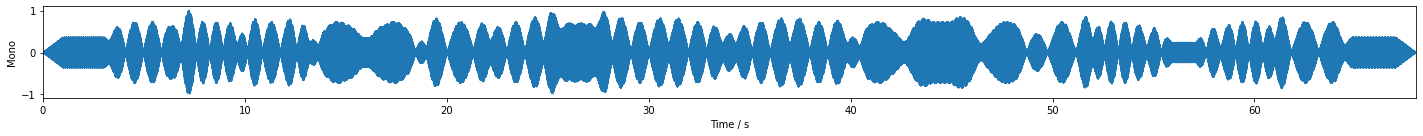

In [90]:
import numpy as np
# import buffer
# import buffer3 as buffer

import wavestacker as buffer
import importlib; importlib.reload(buffer)

def delay(audio, time, depth, decay=0.7, sample_rate=44100):
    delays = buffer.MonoMixer(sample_rate=sample_rate)
    amp = 1
    for i in range(depth):
        delays.add(audio,amp,i*time)
        amp = amp * decay
    t,y = delays.get_mix()
    return y

length = 30
sample_rate = 44100
sample_rate = 400
mixer = buffer.MonoMixer(sample_rate=sample_rate)
bf = buffer.MonoAudioBuffer(sample_rate=sample_rate)

for i in range(int(length * 0.7)):
    freq = 220 + np.random.randint(5)
    freq = 300 + np.random.randint(5)
    print(freq, end=', ')
    # set_in = np.random.randint(length)
    set_in = i *3
    # duration = np.random.randint(6)
    duration = 6
    amp = np.concatenate(( np.linspace(0,1,sample_rate), np.ones(sample_rate*duration), np.linspace(1,0,sample_rate)))
    y  = np.sin(np.linspace(0,3,(duration+2)*sample_rate) * freq * (np.pi * 2))
    y = y * amp
    # y = delay(y, 0.5, 10)
    
    mixer.add(y,1,set_in)

t,y = mixer.get_mix()

# y = delay(y, 0.3, 10)
print(mixer)
print(mixer.tracks[-1])

bf.add_audio_data(y)
bf.plot()
bf.play()

In [52]:
# Correct instantiation
track = buffer.MonoTrack(data=[np.zeros(int(44100*3.3))], position=0.0, name='My Track', sample_rate=44100, amplitude=1.0)
# track
# Incorrect instantiation example to avoid
# track = buffer.MonoTrack(data=[], position=0.0, name='My Track', sample_rate="44100", amplitude=1.0)  # sample_rate as a string
track

MonoTrack, 0.0s (name="My Track", position=0.0, amplitude=1.0)

In [ ]:
import numpy as np
import buffer
import buffer3 as buffer
import importlib; importlib.reload(buffer)

def delay(audio, time, depth, decay=0.7):
    delays = buffer.MonoMixer()
    amp = 1
    for i in range(depth):
        delays.add(audio,amp,i*time)
        amp = amp * decay
    t,y = delays.get_mix()
    return y

# length = 30
mixer = buffer.MonoMixer()

freq = 440
duration = 12
for i in range(5):
    freq += i * 10
    set_in = i * 3
    t = np.linspace(0,3,(duration+2)*44100)
    amp = np.concatenate(( np.linspace(0,1,44100), np.ones(44100*duration), np.linspace(1,0,44100)))
    y  = np.sin(t * freq * (np.pi * 2))
    mixer.add(y,amp,set_in)

for i in range(5):
    freq -= i * 10
    set_in = 5 * 3 + i * 3
    t = np.linspace(0,3,(duration+2)*44100)
    amp = np.concatenate(( np.linspace(0,1,44100), np.ones(44100*duration), np.linspace(1,0,44100)))
    y  = np.sin(t * freq * (np.pi * 2))
    mixer.add(y,amp,set_in)

t,y = mixer.get_mix()
# y = delay(y, 0.3, 10)
print(mixer)

bf = buffer.MonoAudioBuffer()
bf.add_audio_data(t,y)
bf.plot()
bf.play()

In [ ]:
import buffer3 as buffer
import importlib; importlib.reload(buffer)
import numpy as np

def delay(audio, time=0.1, depth=10, decay=0.7):
    delays = buffer.MonoMixer()
    amp = 1
    for i in range(depth):
        delays.add(audio,amp,i*time)
        amp = amp * decay
    t,y = delays.get_mix()
    return y

sample_rate = 44100
mixer = buffer.MonoMixer()
duration = 0.2 # seconds

for i in range(100): 
    frequency = 110 *  np.random.randint(10) 
    # frequency = 2**(np.random.randint(12)/12) * 220
    time_array = np.linspace(0, duration, int(sample_rate * duration))
    amplitude_array = np.sin(2 * np.pi * frequency * time_array)
    amplitude_array = delay(amplitude_array, 0.05)
    mixer.add(amplitude_array, 1, i*duration)
    
bf = buffer.MonoAudioBuffer()
bf.add_audio_data(*mixer.get_mix())
bf.plot()
# bf.write_to_wav('ringing_random.wav')
bf.play()

In [ ]:
import tempfile
tempfile.mkdtemp(suffix='.wav')

In [ ]:
import buffer3 as buffer
import numpy as np

sample_rate = 44100

def bandpass_filter(signal, center_frequency=1000, bandwidth=100, sample_rate=44100):
    t = np.linspace(0, len(signal) / sample_rate, len(signal), endpoint=False)
    filter_kernel = np.exp(-0.5 * ((2 * np.pi * t * bandwidth) ** 2)) * np.cos(2 * np.pi * t * center_frequency)
    pad_width = len(filter_kernel) // 2
    filtered_signal = np.convolve(np.pad(signal, (pad_width, pad_width), mode='constant'), filter_kernel, mode='same')
    filtered_signal = filtered_signal[:len(signal)]
    return filtered_signal / max(abs(filtered_signal))

def drum(frequency, decay):
    'https://www.bluskysoftware.com/audacity/manual/man/risset_drum.html'
    attack  = int(0.02*44100)
    release = int(decay*44100)
    amp = np.concatenate((np.linspace(0,1,attack), np.linspace(1,0,release)**3))
    sine  = np.sin(np.linspace(0, (attack+release)/44100, attack+release ) * frequency * (np.pi * 2))
    enharmonic  = np.sin(np.linspace(0, (attack+release)/44100, attack+release ) * frequency * 2 * (np.pi * 2))
    sub  = np.sin(np.linspace(0, (attack+release)/44100, attack+release ) * frequency / 2 * (np.pi * 2))
    white_noise = np.random.rand(attack+release) * 2 - 1
    noise = bandpass_filter(white_noise, frequency, 100)
    mix = 0.6 * sine + 0.1 * enharmonic + 0.1 * noise  + 0.2 * sub
    return mix , amp

def delay(audio, time=0.1, depth=10, decay=0.7):
    delays = buffer.MonoMixer()
    amp = 1
    for i in range(depth):
        delays.add(audio,amp,i*time)
        amp = amp * decay
    t,y = delays.get_mix()
    return y

def cycle_through_list(items):
    while True: 
        for item in items: yield item

notes = [200,240]*4 + [180,240]*4
note = cycle_through_list(notes)
        
bassline = buffer.MonoMixer()
joined = buffer.MonoMixer()
drums = buffer.MonoMixer()

duration = 0.3 # seconds
frequency = 300
for i in range(200):
    frequency = next(note)
    position = i * duration
    time_array = np.linspace(0, duration, int(sample_rate * duration))
    amplitude_array = np.sign(np.sin(2 * np.pi * frequency * time_array))
    amplitude_array = delay(amplitude_array, 0.05)
    bassline.add(amplitude_array, 0.3, position)
joined.add(bassline.get_mix()[1])


duration = 2
for i in range(25):
    # frequency = next(note)
    frequency = 150
    position = i * 0.3 * 4
    # time_array = np.linspace(0, duration, int(sample_rate * duration))
    # amplitude_array = np.sin(2 * np.pi * frequency * time_array) + np.sin(2 * np.pi * frequency*2 * time_array)
    # attack  = np.linspace(0,1, int(0.05 * sample_rate))
    # release = np.linspace(1,0, int(0.4 * sample_rate)) ** 2
    # # print(len(time_array) , len(attack) ,len(release))
    # silence = np.zeros(len(time_array) - len(attack) - len(release))
    # envelope = np.concatenate((attack, release, silence))
    # amplitude_array = delay(amplitude_array, 0.05) * 0.6
    amplitude_array, envelope = drum(frequency, duration)
    drums.add(amplitude_array, envelope * 2, position)
    # drums.add(*drum(frequency, duration), position)
    
joined.add(drums.get_mix()[1])

print(joined)
bf = buffer.MonoAudioBuffer()
bf.add_audio_data(*joined.get_mix())
bf.play()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
Fs = 10000  # Sampling frequency
t = np.arange(0, 1, 1/Fs)  # Time vector
Fc = 2000  # Carrier frequency
Fm = 10  # Modulating frequency
beta = 5  # Modulation index

# Generate the carrier signal
carrier_signal = np.cos(2 * np.pi * Fc * t)

# Generate the modulating signal
modulating_signal = np.sin(2 * np.pi * Fm * t)
modulating_signal = np.sign(np.sin(t * Fm * (np.pi * 2)))

# Frequency modulation
fm_signal = np.cos(2 * np.pi * Fc * t + beta * modulating_signal)


fig, axs = plt.subplots(3,1, figsize=(15, 8))


# Plotting
axs[0].plot(t, carrier_signal)
axs[0].set_title('Carrier Signal')

axs[1].plot(t, modulating_signal)
axs[1].set_title('Modulating Signal')

axs[2].plot(t, fm_signal)
axs[2].set_title('Frequency Modulated Signal')
for ax in axs: ax.set_xlim(0,0.1)

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def frequency_modulation(carrier, modulation, sample_rate=44100):
    t = np.arange(len(carrier)) / sample_rate
    # Modulation index (assuming carrier and modulation are normalized between -1 and 1)
    beta = max(modulation)  # Assuming modulation is normalized
    fm_signal = np.cos(2 * np.pi * carrier * t + beta * modulation)
    return fm_signal

def frequency_modulation(carrier, modulation, sample_rate=44100):
    t = np.arange(len(carrier)) / sample_rate
    # Modulation index (assuming carrier and modulation are normalized between -1 and 1)
    beta = max(modulation)  # Assuming modulation is normalized
    # Frequency modulation
    fm_signal = np.cos(2 * np.pi * carrier * t + beta * modulation)
    # Center the signal around zero
    fm_signal -= np.mean(fm_signal)
    return fm_signal

Fs = 10000  # Sampling frequency
Fc = 1000   # Carrier frequency
Fm = 50     # Modulating frequency
beta = 5    # Modulation index

t = np.linspace(0,1, 44100)
# Generate the carrier signal
carrier_signal = np.cos(2 * np.pi * Fc * t)
# Generate the modulating signal
modulating_signal = np.sin(2 * np.pi * Fm * t)
fm_signal = frequency_modulation(carrier_signal, modulating_signal)

fig, axs = plt.subplots(3,1, figsize=(15, 8))


# Plotting
axs[0].plot(t, carrier_signal)
axs[0].set_title('Carrier Signal')

axs[1].plot(t, modulating_signal)
axs[1].set_title('Modulating Signal')

axs[2].plot(t, fm_signal)
axs[2].set_title('Frequency Modulated Signal')
for ax in axs: ax.set_xlim(0,0.1)

plt.tight_layout()
plt.show()
